#EfficientNetB0 Model Experiments
In this notebook, EfficientNetB0 model will be experimented to find out the best model for GTSRB dataset.

The whole notebook will be divided into 6 parts.

- **Part 1:** **Dataset** - Dataset will be loaded and preprocessed in this part.
- **Part 2:** **Define functions** - Training function, Accuracy and loss curve function and evaluate function will be defined here.
- **Part 3:** **Fine-Tuning** - Different layer combinations of the pre-trained model will be experimented.
- **Part 4:** **Hyperparameter tuning**
  - 4.1 Learning Rate (LR) Experiments
  - 4.2 Batch Size Experiments
- **Part 5: Train Best model for more epochs**
- **Part 6: Train best model on oversampled dataset**

#Mount Google Drive and import libraries

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import random

# Set the seed
random.seed(42)

#Part 1: Dataset

##Load training data

In [3]:
# Define paths to dataset
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
num_classes = 43

# Define function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

## Print total number of images in the training dataset

In [4]:
# Store the images and labels in two new folders
train_images, train_labels = images, labels

# Print dataset shape
print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')

train_images shape: (39209, 32, 32, 3)
train_labels shape: (39209, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [5]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


## Load test data

In [6]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


##Total Number of images in the test data

In [7]:
# Print test dataset shape
print(f'X_test shape: {X_test.shape}')

X_test shape: (12630, 32, 32, 3)


##Load ground truth

In [8]:
# Load the ground truth file (downloaded separately)
ground_truth = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

#Part 2: Define Functions

##Compile and train model

In [9]:
# define a function to train the model
def train_model(model, lr, BATCH_SIZE, EPOCHS):
    """
    This function will train the model.
    Parameters:
        model: the model that will be trained
        lr: learning rate
        BATCH_SIZE: batch size
        EPOCHS: number of epochs
    """
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history

##Accuracy and loss curve

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# write a function to visualize curves
def visualize_training_curves(history):

    """
    This function will plot the accuracy and loss curve of the trained model.
    parameter:
        history: It contains training history of the model
    """

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # set epochs to start from 1
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    axes[0].plot(epochs, history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0].plot(epochs, history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='lower right')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot loss
    axes[1].plot(epochs, history.history['loss'], label='train_loss', color="green")
    axes[1].plot(epochs, history.history['val_loss'], label='val_loss', color="red")
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    plt.tight_layout()
    plt.show()

##Evaluate model on test data

In [11]:
# Write a function to evaluate the trained model
def evaluate_model(model, X_test, ground_truth_df):

    """
    This function will evaluate the trained model on test data.
    Parameters:
        model: The trained model
        X_test: contains the test dataset
        ground_truth: contains the true class of the test images
    """

    # Predict class probabilities
    predictions = model.predict(X_test)

    # Get the class index with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)

    # Save predicted classes and the image file names to a dataframe
    predictions_df = pd.DataFrame({
        'Filename': test_img_names,
        'Predicted Class': predicted_classes
    })

    # Ensure the filenames are sorted in ascending order in the result file
    predictions_df = predictions_df.sort_values(by='Filename')

    # Merge both dataframes on the 'Filename' column
    merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

    # Calculate accuracy by comparing predicted classes with actual classes
    accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

    print(f"Learning rate: {lr},\nBatch Size: {BATCH_SIZE},")

    # get the lowest validation loss epoch
    epoch_with_lowest_val_loss = np.argmin(history.history['val_loss'])

    # get validation accuracy of that epoch
    val_accuracy = history.history['val_accuracy'][epoch_with_lowest_val_loss]

    # print validation accuracy and test accuracy
    print(f"Validation accuracy: {val_accuracy*100:.2f}%,\nTest Accuracy: {accuracy * 100:.2f}%.")

#Part 3: Fine-Tuning (Layer Experiments)

##Load Model:

###Trainable base model layers: 0, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 680,491 (2.60 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

##Compile and train the model

Trainable base model layers: 0
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.0495 - loss: 3.6677 - val_accuracy: 0.0622 - val_loss: 3.5478
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0561 - loss: 3.5810 - val_accuracy: 0.0719 - val_loss: 3.5131
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0570 - loss: 3.5663 - val_accuracy: 0.0587 - val_loss: 3.5268
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0601 - loss: 3.5461 - val_accuracy: 0.0543 - val_loss: 3.5361
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.0613 - loss: 3.5383 - val_accuracy: 0.0566 - val_loss: 3.5138


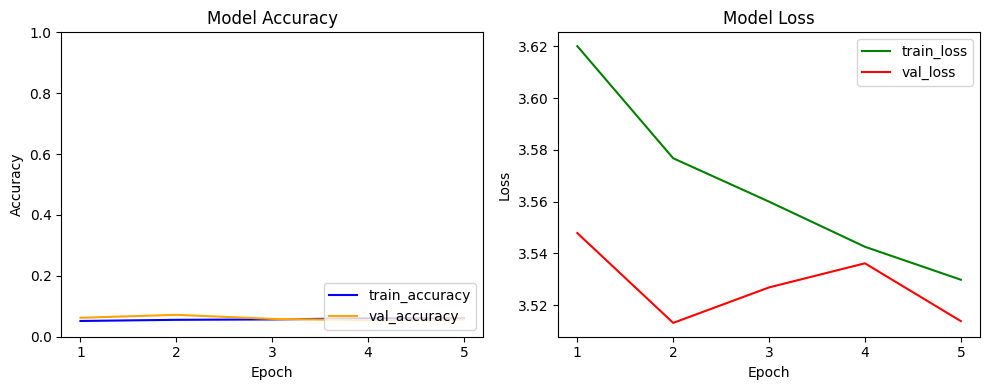

395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 7.19%,
Test Accuracy: 7.40%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: 0\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 191, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze some layers of base model
for layer in base_model.layers[:47]:
    layer.trainable = False
    print(layer)

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

<InputLayer name=input_layer_2, built=True>
<Rescaling name=rescaling_2, built=True>
<Normalization name=normalization_1, built=True>
<Rescaling name=rescaling_3, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=True>

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 4,668,949 (17.81 MB)

 Non-trainable params: 63,673 (248.73 KB)

##Compile and train the model

Trainable base model layers: Top 191
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 111s 56ms/step - accuracy: 0.3619 - loss: 2.3059 - val_accuracy: 0.2318 - val_loss: 3.3926
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 75s 16ms/step - accuracy: 0.7368 - loss: 0.8682 - val_accuracy: 0.3912 - val_loss: 3.0208
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8087 - loss: 0.6204 - val_accuracy: 0.3125 - val_loss: 3.6777
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8496 - loss: 0.4932 - val_accuracy: 0.4476 - val_loss: 2.1800
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8720 - loss: 0.4178 - val_accuracy: 0.4120 - val_loss: 2.6463


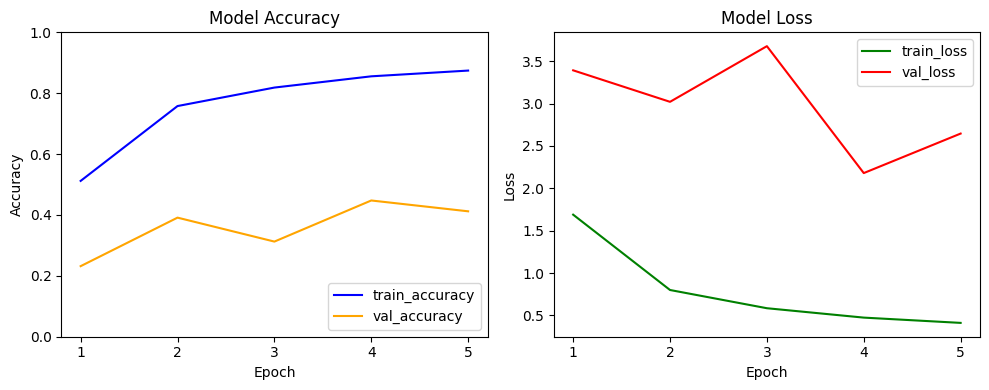

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 44.76%,
Test Accuracy: 39.47%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 191\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 220, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze some layers of base model
for layer in base_model.layers[:18]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 4,685,663 (17.87 MB)

 Non-trainable params: 46,959 (183.44 KB)

##Compile and train the model

Trainable base model layers: Top 220
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 133s 64ms/step - accuracy: 0.4444 - loss: 1.9464 - val_accuracy: 0.6257 - val_loss: 1.3500
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 66s 20ms/step - accuracy: 0.8663 - loss: 0.4340 - val_accuracy: 0.6761 - val_loss: 1.4404
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9184 - loss: 0.2635 - val_accuracy: 0.7510 - val_loss: 0.9683
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9385 - loss: 0.2022 - val_accuracy: 0.7489 - val_loss: 0.9279
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9478 - loss: 0.1714 - val_accuracy: 0.9457 - val_loss: 0.1780


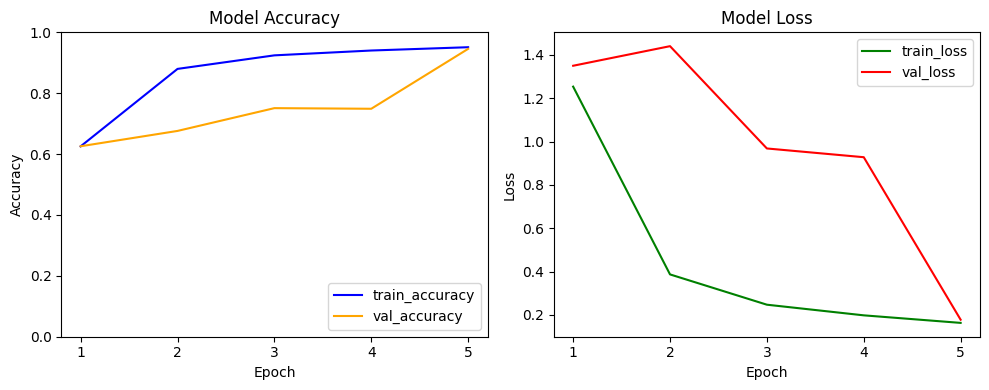

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 94.57%,
Test Accuracy: 90.27%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 220\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 230, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze some layers of base model
for layer in base_model.layers[:8]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 4,687,111 (17.88 MB)

 Non-trainable params: 45,511 (177.78 KB)

##Compile and train the model

Trainable base model layers: Top 230
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 128s 64ms/step - accuracy: 0.4919 - loss: 1.7826 - val_accuracy: 0.6125 - val_loss: 1.7433
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 67s 20ms/step - accuracy: 0.8884 - loss: 0.3694 - val_accuracy: 0.2997 - val_loss: 4.0020
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9370 - loss: 0.2114 - val_accuracy: 0.2385 - val_loss: 4.2521
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9524 - loss: 0.1658 - val_accuracy: 0.1719 - val_loss: 4.5570
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9618 - loss: 0.1262 - val_accuracy: 0.1313 - val_loss: 5.3302


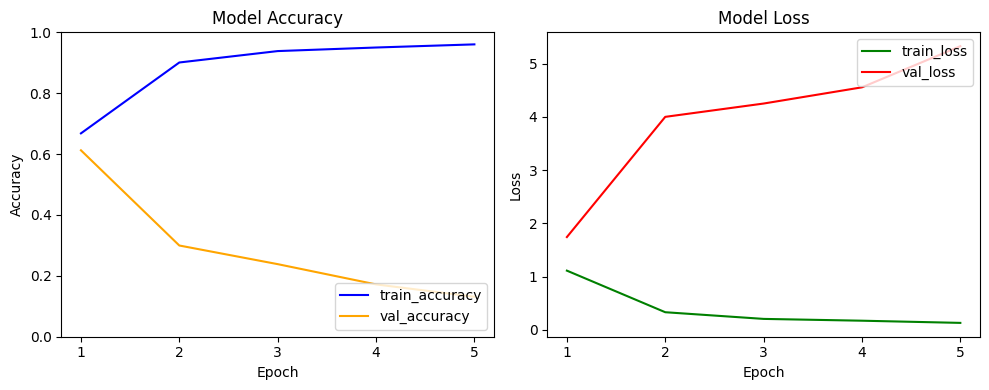

395/395 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 61.25%,
Test Accuracy: 56.37%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 230\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: Top 233, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze some layers of base model
for layer in base_model.layers[:5]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 4,688,039 (17.88 MB)

 Non-trainable params: 44,583 (174.16 KB)

##Compile and train the model

Trainable base model layers: Top 233
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 131s 63ms/step - accuracy: 0.6348 - loss: 1.3009 - val_accuracy: 0.9523 - val_loss: 0.1639
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.9408 - loss: 0.1957 - val_accuracy: 0.9662 - val_loss: 0.1226
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9638 - loss: 0.1205 - val_accuracy: 0.9838 - val_loss: 0.0522
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9714 - loss: 0.0979 - val_accuracy: 0.9652 - val_loss: 0.1407
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9738 - loss: 0.0881 - val_accuracy: 0.9888 - val_loss: 0.0427


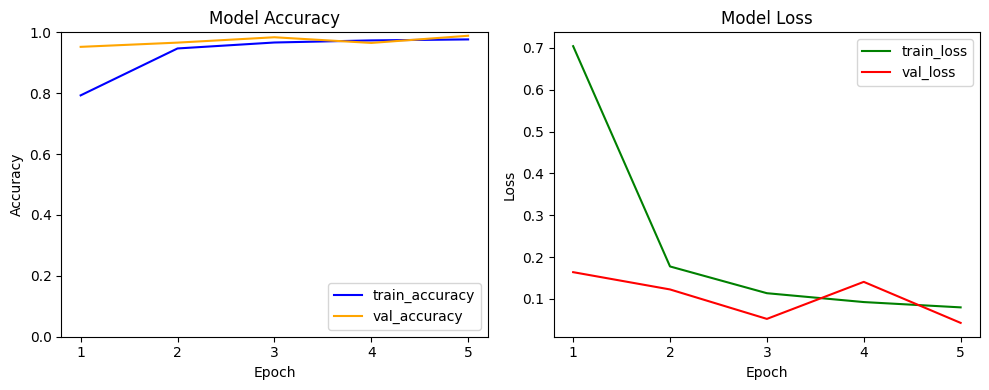

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.88%,
Test Accuracy: 95.37%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Top 233\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Trainable base model layers: All, Learning rate: 0.001, Batch size = 32

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze all layers of base model
for layer in base_model.layers:
    layer.trainable = True

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1, 1, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,622 (18.05 MB)

 Trainable params: 4,688,039 (17.88 MB)

 Non-trainable params: 44,583 (174.16 KB)

##Compile and train the model

Trainable base model layers: All
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 125s 65ms/step - accuracy: 0.6152 - loss: 1.3600 - val_accuracy: 0.8831 - val_loss: 0.4580
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 70s 22ms/step - accuracy: 0.9410 - loss: 0.1984 - val_accuracy: 0.9767 - val_loss: 0.0832
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9620 - loss: 0.1318 - val_accuracy: 0.9816 - val_loss: 0.0619
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9730 - loss: 0.0955 - val_accuracy: 0.9881 - val_loss: 0.0389
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.9792 - loss: 0.0769 - val_accuracy: 0.9864 - val_loss: 0.0515


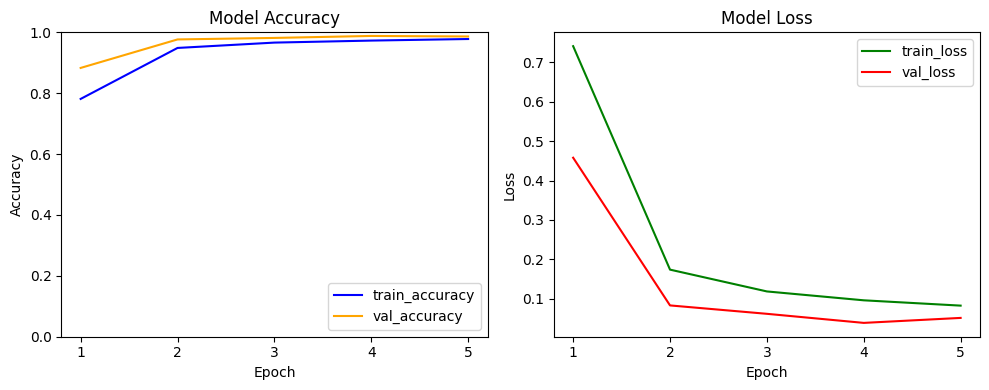

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.81%,
Test Accuracy: 94.82%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: All\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv and block1 layers with the top layers

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block1a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_12, built=True>
<Rescaling name=rescaling_12, built=True>
<Normalization name=normalization_6, built=True>
<Rescaling name=rescaling_13, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=batch_normalization_6, built=True>
<Flatten name=flatten_6, built=True>
<Dense name=dense_12, built=True>
<Dense name=dense_13, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_12 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 32, 32, 3)      │              7 │ rescaling_12[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_13 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ normalization_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_13[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 2,122,266 (8.10 MB)

 Trainable params: 2,122,099 (8.10 MB)

 Non-trainable params: 167 (672.00 B)

###Compile and train the model

Train stem_conv and block1 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7765 - loss: 0.8929 - val_accuracy: 0.9584 - val_loss: 0.1797
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9863 - loss: 0.0695 - val_accuracy: 0.9681 - val_loss: 0.1141
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9953 - loss: 0.0291 - val_accuracy: 0.9778 - val_loss: 0.0891
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9990 - loss: 0.0129 - val_accuracy: 0.9778 - val_loss: 0.0811
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9998 - loss: 0.0042 - val_accuracy: 0.9829 - val_loss: 0.0651


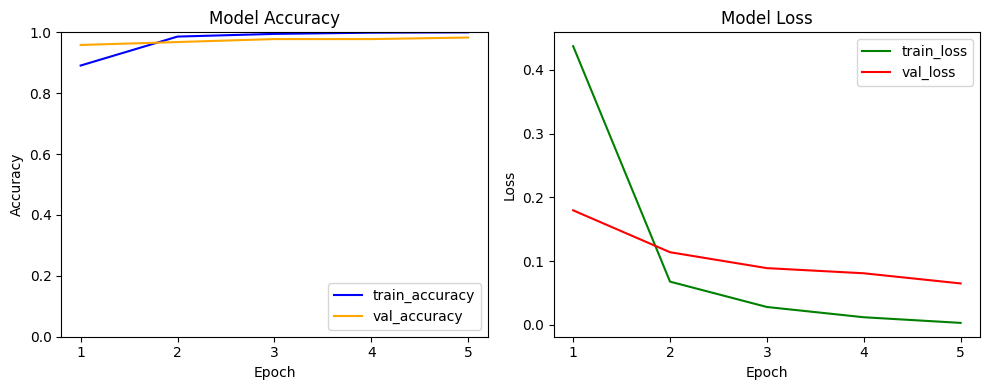

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.29%,
Test Accuracy: 91.01%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv and block1 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1 and block2 layers with the top layers

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block2a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_13, built=True>
<Rescaling name=rescaling_14, built=True>
<Normalization name=normalization_7, built=True>
<Rescaling name=rescaling_15, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=Tr

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_14 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_7           │ (None, 32, 32, 3)      │              7 │ rescaling_14[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_15 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ normalization_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_15[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 817,982 (3.12 MB)

 Trainable params: 817,383 (3.12 MB)

 Non-trainable params: 599 (2.34 KB)

###Compile and train the model

Train stem_conv, block1 and block2 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8191 - loss: 0.7436 - val_accuracy: 0.9908 - val_loss: 0.0519
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9975 - loss: 0.0177 - val_accuracy: 0.9874 - val_loss: 0.0510
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9991 - loss: 0.0079 - val_accuracy: 0.9926 - val_loss: 0.0248
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.9909 - val_loss: 0.0336
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9912 - val_loss: 0.0338


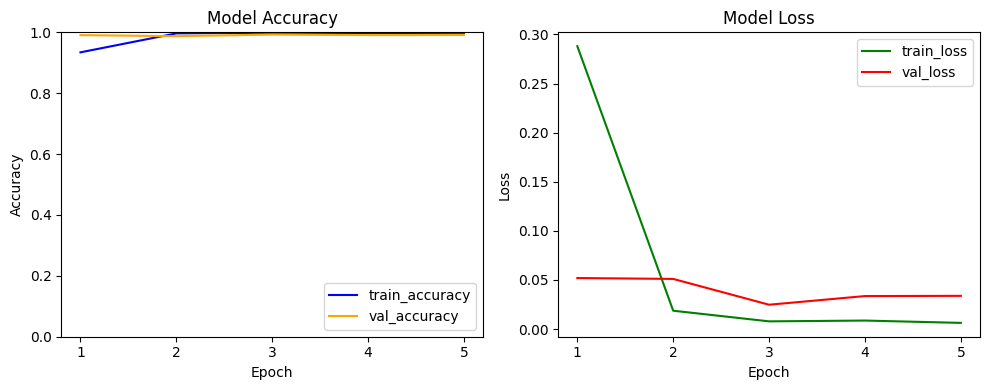

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.26%,
Test Accuracy: 96.14%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1 and block2 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2 and block3 layers with the top layers

In [ ]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block3a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_14, built=True>
<Rescaling name=rescaling_16, built=True>
<Normalization name=normalization_8, built=True>
<Rescaling name=rescaling_17, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=Tr

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_16 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_8           │ (None, 32, 32, 3)      │              7 │ rescaling_16[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_17 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ normalization_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_17[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 386,570 (1.47 MB)

 Trainable params: 384,691 (1.47 MB)

 Non-trainable params: 1,879 (7.34 KB)

###Compile and train the model

Train stem_conv, block1, block2 and block3 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8005 - loss: 0.8115 - val_accuracy: 0.9893 - val_loss: 0.0485
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9969 - loss: 0.0184 - val_accuracy: 0.9906 - val_loss: 0.0336
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9975 - loss: 0.0102 - val_accuracy: 0.9894 - val_loss: 0.0338
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9976 - loss: 0.0097 - val_accuracy: 0.9917 - val_loss: 0.0284
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9981 - loss: 0.0076 - val_accuracy: 0.9893 - val_loss: 0.0397


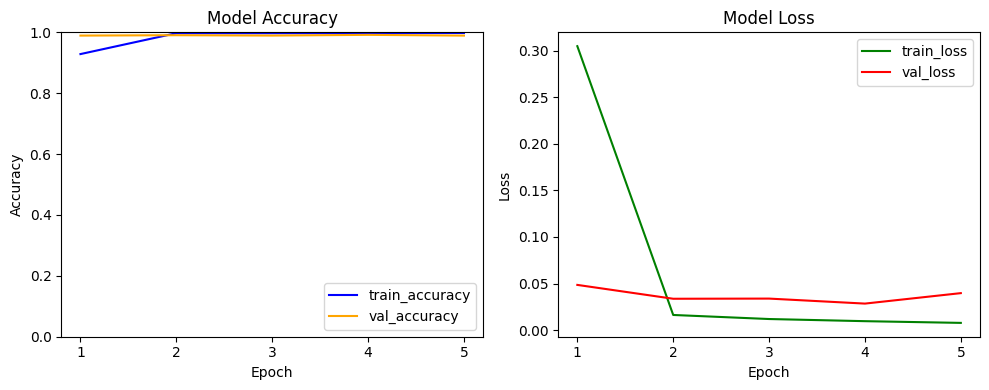

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.17%,
Test Accuracy: 96.58%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2 and block3 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2, block3 and block4 layers with the top layers

In [24]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block4a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_6, built=True>
<Rescaling name=rescaling_12, built=True>
<Normalization name=normalization_6, built=True>
<Rescaling name=rescaling_13, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=Tru

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_12 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 32, 32, 3)      │              7 │ rescaling_12[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_13 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ normalization_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_13[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 293,310 (1.12 MB)

 Trainable params: 289,271 (1.10 MB)

 Non-trainable params: 4,039 (15.78 KB)

###Compile and train the model

Train stem_conv, block1, block2, block3 and block4 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.7714 - loss: 0.8944 - val_accuracy: 0.9768 - val_loss: 0.0854
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.9943 - loss: 0.0275 - val_accuracy: 0.9906 - val_loss: 0.0325
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9959 - loss: 0.0160 - val_accuracy: 0.9901 - val_loss: 0.0333
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9941 - loss: 0.0203 - val_accuracy: 0.9952 - val_loss: 0.0177
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9922 - val_loss: 0.0238


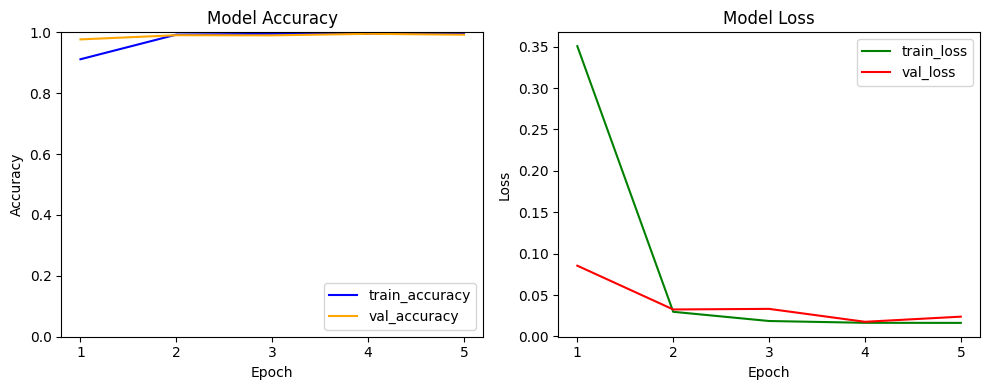

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.52%,
Test Accuracy: 96.27%.


In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2, block3 and block4 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2, block3, block4 and block5 layers with the top layers

In [16]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block5a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_2, built=True>
<Rescaling name=rescaling_4, built=True>
<Normalization name=normalization_2, built=True>
<Rescaling name=rescaling_5, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=True>

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 32, 32, 3)      │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 696,954 (2.66 MB)

 Trainable params: 686,611 (2.62 MB)

 Non-trainable params: 10,343 (40.41 KB)

###Compile and train the model

Train stem_conv, block1, block2, block3, block4 and block5 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.7793 - loss: 0.8393 - val_accuracy: 0.9758 - val_loss: 0.0761
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.9881 - loss: 0.0435 - val_accuracy: 0.9839 - val_loss: 0.0546
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9913 - loss: 0.0295 - val_accuracy: 0.9899 - val_loss: 0.0314
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9923 - loss: 0.0268 - val_accuracy: 0.9841 - val_loss: 0.0664
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9928 - loss: 0.0251 - val_accuracy: 0.9711 - val_loss: 0.1102


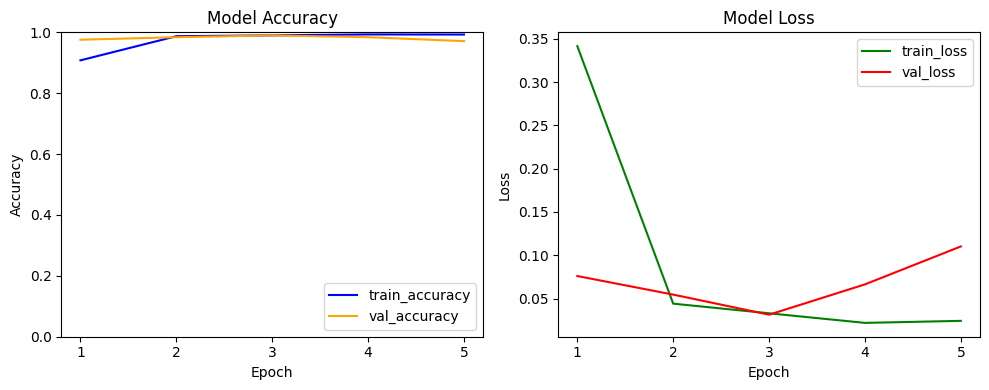

395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.99%,
Test Accuracy: 95.34%.


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2, block3, block4 and block5 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2, block3, block4, block5 and block6 layers with the top layers

In [18]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block6a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_3, built=True>
<Rescaling name=rescaling_6, built=True>
<Normalization name=normalization_3, built=True>
<Rescaling name=rescaling_7, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=True>

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 32, 32, 3)      │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 1,254,414 (4.79 MB)

 Trainable params: 1,235,175 (4.71 MB)

 Non-trainable params: 19,239 (75.16 KB)

###Compile and train the model

Train stem_conv, block1, block2, block3, block4, block5 and block6 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - accuracy: 0.7306 - loss: 1.0197 - val_accuracy: 0.9728 - val_loss: 0.0899
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9778 - loss: 0.0742 - val_accuracy: 0.9796 - val_loss: 0.0623
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9874 - loss: 0.0413 - val_accuracy: 0.9795 - val_loss: 0.0728
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9866 - loss: 0.0456 - val_accuracy: 0.9436 - val_loss: 0.1907
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9880 - loss: 0.0403 - val_accuracy: 0.9870 - val_loss: 0.0602


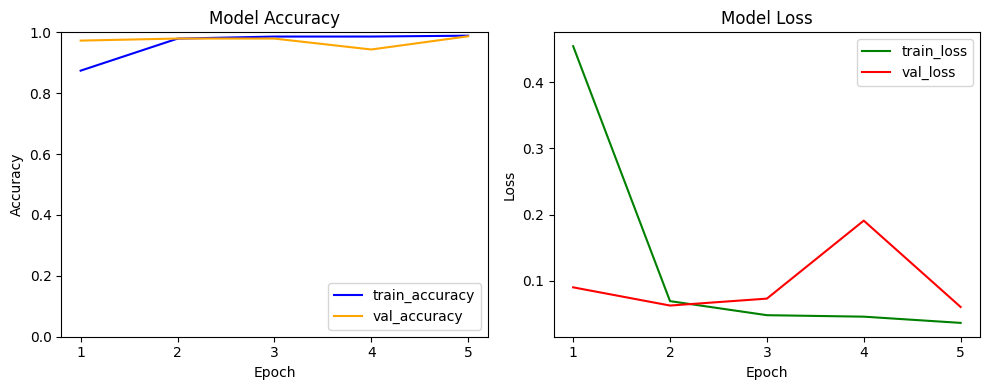

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.70%,
Test Accuracy: 95.08%.


In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2, block3, block4, block5 and block6 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2, block3, block4, block5, block6 and block7 layers with the top layers

In [20]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('block7a_project_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_4, built=True>
<Rescaling name=rescaling_8, built=True>
<Normalization name=normalization_4, built=True>
<Rescaling name=rescaling_9, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=True>

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 32, 32, 3)      │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 3,821,262 (14.58 MB)

 Trainable params: 3,781,799 (14.43 MB)

 Non-trainable params: 39,463 (154.16 KB)

###Compile and train the model

Train stem_conv, block1, block2, block3, block4, block5, block6 and block7 layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 134s 67ms/step - accuracy: 0.6594 - loss: 1.2052 - val_accuracy: 0.9528 - val_loss: 0.1555
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - accuracy: 0.9624 - loss: 0.1265 - val_accuracy: 0.9746 - val_loss: 0.0884
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9748 - loss: 0.0843 - val_accuracy: 0.9783 - val_loss: 0.0932
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9812 - loss: 0.0663 - val_accuracy: 0.9851 - val_loss: 0.0453
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9852 - loss: 0.0505 - val_accuracy: 0.9815 - val_loss: 0.0688


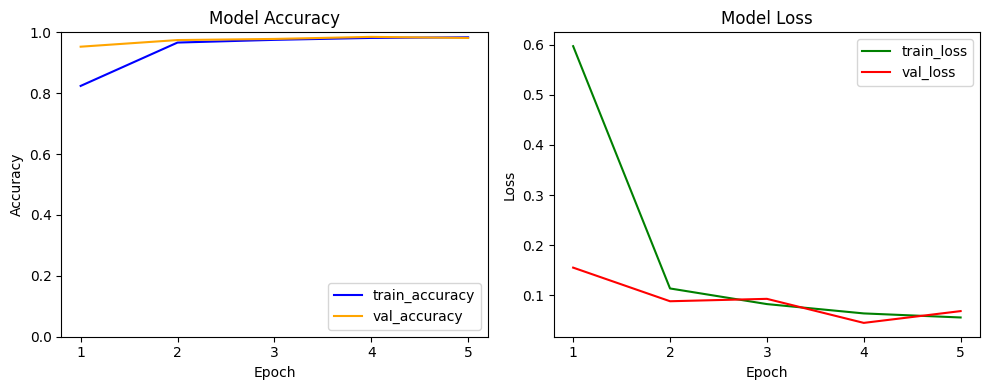

395/395 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.51%,
Test Accuracy: 94.92%.


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2, block3, block4, block5, block6 and block7 layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Load Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2, block3, block4, block5, block6, block7 and top_conv layers with the top layers

In [22]:
# Load the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with custom layers
x = base_model.get_layer('top_conv').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Train all layers
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_5, built=True>
<Rescaling name=rescaling_10, built=True>
<Normalization name=normalization_5, built=True>
<Rescaling name=rescaling_11, built=True>
<ZeroPadding2D name=stem_conv_pad, built=True>
<Conv2D name=stem_conv, built=True>
<BatchNormalization name=stem_bn, built=True>
<Activation name=stem_activation, built=True>
<DepthwiseConv2D name=block1a_dwconv, built=True>
<BatchNormalization name=block1a_bn, built=True>
<Activation name=block1a_activation, built=True>
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True>
<Reshape name=block1a_se_reshape, built=True>
<Conv2D name=block1a_se_reduce, built=True>
<Conv2D name=block1a_se_expand, built=True>
<Multiply name=block1a_se_excite, built=True>
<Conv2D name=block1a_project_conv, built=True>
<BatchNormalization name=block1a_project_bn, built=True>
<Conv2D name=block2a_expand_conv, built=True>
<BatchNormalization name=block2a_expand_bn, built=True>
<Activation name=block2a_expand_activation, built=Tru

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_10 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_5           │ (None, 32, 32, 3)      │              7 │ rescaling_10[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_11 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ normalization_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_11[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,727,502 (18.03 MB)

 Trainable params: 4,685,479 (17.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

###Compile and train the model

Train stem_conv, block1, block2, block3, block4, block5, block6, block7 and top_conv layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 136s 69ms/step - accuracy: 0.6707 - loss: 1.1514 - val_accuracy: 0.9394 - val_loss: 0.2062
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - accuracy: 0.9508 - loss: 0.1675 - val_accuracy: 0.9477 - val_loss: 0.1939
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9668 - loss: 0.1149 - val_accuracy: 0.9805 - val_loss: 0.0621
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9787 - loss: 0.0748 - val_accuracy: 0.9653 - val_loss: 0.1422
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9828 - loss: 0.0632 - val_accuracy: 0.9895 - val_loss: 0.0358


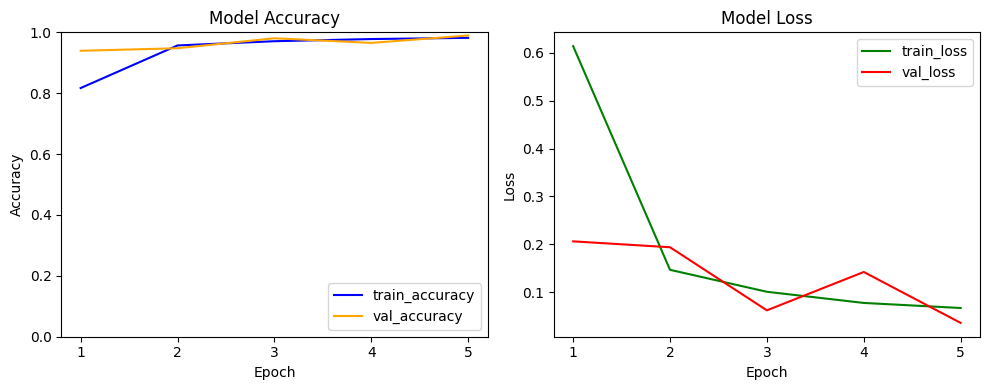

395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.95%,
Test Accuracy: 95.17%.


In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train stem_conv, block1, block2, block3, block4, block5, block6, block7 and top_conv layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Fine Tuning (Layer experiments) Results:

Trainable base model layers: 0
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 7.19%,
Test Accuracy: 7.40%.

Trainable base model layers: 191
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 44.76%,
Test Accuracy: 39.47%.

Trainable base model layers: 220
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 94.57%,
Test Accuracy: 90.27%.

Trainable base model layers: 230
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 61.25%,
Test Accuracy: 56.37%.

Trainable base model layers: 233
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.88%,
Test Accuracy: 95.37%.

Trainable base model layers: all
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.81%,
Test Accuracy: 94.82%.


##Split EfficientNetB0 Model
Train stem_conv and block1
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.29%,
Test Accuracy: 91.01%.

Train stem_conv, block1, block2
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.26%,
Test Accuracy: 96.14%.

**Train stem_conv, block1, block2, block3. Learning rate: 0.001, Batch Size: 32, Validation accuracy: 99.17%, Test Accuracy: 96.58%.**

Train stem_conv, block1, block2, block3, block4
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.52%,
Test Accuracy: 96.27%.

Train stem_conv, block1, block2, block3, block4, block5
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.99%,
Test Accuracy: 95.34%.

Train stem_conv, block1, block2, block3, block4, block5, block6
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.70%,
Test Accuracy: 95.08%.

Train stem_conv, block1, block2, block3, block4, block5, block6, block7
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.51%,
Test Accuracy: 94.92%.

Train stem_conv, block1, block2, block3, block4, block5, block6, block7 and top_conv
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.95%,
Test Accuracy: 95.17%.

**Hyperparameter tuning will be experimented in the next steps on the best model to find the optimal learning rate and batch size for the model.**

#Part 4: Hyperparameter Tuning

In the following cell, different learning rates and batch sizes will be experimented on the model. The batch size will be set to 32 during learning rate experiments. During experiments model will be trained for 5 epochs only. Then the best models will be trained for more epochs.

##Load Best Model:

###Split the EfficientNetB0 model: Train stem_conv, block1, block2 and block3 layers with the top layers

In [12]:
# write a function to load best EfficientNetB0 model
def load_EfficientNetB0_model_block3a_project_conv(input_shape):

    """
    This function will load EfficientNetB0 model with
    stem_conv, block1, block2 and block3 layers and top layers
    It will accept input shape as parameter
    """

    # Load the EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with custom layers
    x = base_model.get_layer('block3a_project_conv').output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    return model

# Call the function
model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 32, 32, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 33, 33, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 16, 16, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 16, 16, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 16, 16, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 16, 16, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 16, 16, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 16, 16, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 386,570 (1.47 MB)

 Trainable params: 384,691 (1.47 MB)

 Non-trainable params: 1,879 (7.34 KB)

##4.1 Learning Rate (LR) Experiments

###Compile and train the model

###Learning rate 0.0001, 0.00001

*********************************************************
Experiment 1 starts
Train the best model: stem_conv, block1, block2 and block3 layers with top layers
Training model with learning rate = 0.0001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - accuracy: 0.4592 - loss: 2.2798 - val_accuracy: 0.8665 - val_loss: 0.7147
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9139 - loss: 0.5174 - val_accuracy: 0.9717 - val_loss: 0.2275
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9761 - loss: 0.1905 - val_accuracy: 0.9885 - val_loss: 0.1065
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9900 - loss: 0.0954 - val_accuracy: 0.9932 - val_loss: 0.0589
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9952 - loss: 0.0524 - val_accuracy: 0.9953 - val_loss: 0.0378


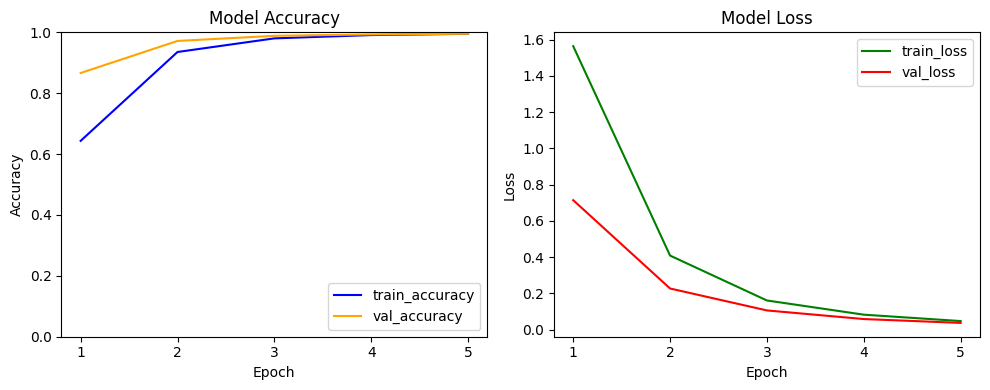

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.53%,
Test Accuracy: 96.61%.
Experiment 1 finish
*********************************************************


*********************************************************
Experiment 2 starts
Train the best model: stem_conv, block1, block2 and block3 layers with top layers
Training model with learning rate = 1e-05 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.1206 - loss: 3.6013 - val_accuracy: 0.3736 - val_loss: 2.7016
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4159 - loss: 2.5304 - val_accuracy: 0.5071 - val_loss: 2.1130
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5288 - loss: 2.0310 - val_accuracy: 0.5928 - val_loss: 1.7566
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6068 - loss: 1.7127 - val_accuracy: 0.6553 - val_loss: 1.4947
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - 

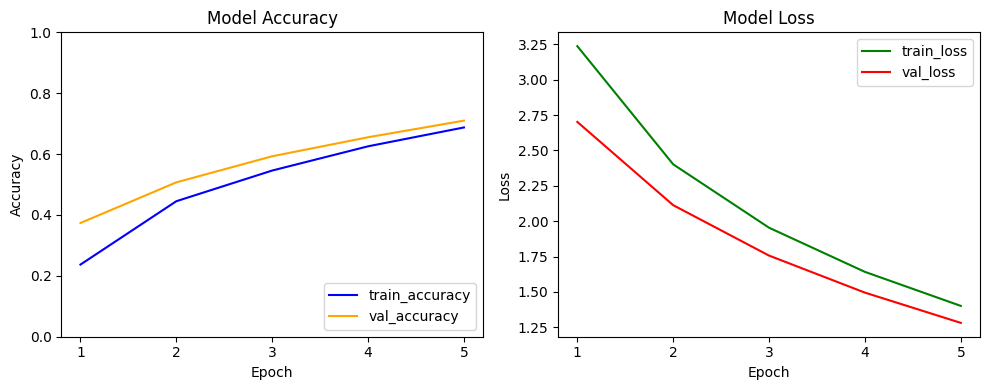

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 70.99%,
Test Accuracy: 66.90%.
Experiment 2 finish
*********************************************************




In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.0001, 0.00001]
BATCH_SIZE = 32
EPOCHS = 5

loop = 1

for lr in learning_rate:

    print(f'*********************************************************')
    print(f'Experiment {loop} starts')

    print(f"Train the best model: stem_conv, block1, block2 and block3 layers with top layers\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Experiment {loop} finish')
    loop += 1

    print(f'*********************************************************\n\n')

###Compile and train the model

###Learning rate 0.01

*********************************************************
Experiment 3 starts
Train the best model:
Training model with learning rate = 0.01 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.8162 - loss: 0.7112 - val_accuracy: 0.9271 - val_loss: 0.2839
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9585 - loss: 0.1380 - val_accuracy: 0.9348 - val_loss: 0.2442
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9592 - loss: 0.1575 - val_accuracy: 0.9584 - val_loss: 0.1866
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9686 - loss: 0.1122 - val_accuracy: 0.9527 - val_loss: 0.1930
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9710 - loss: 0.1147 - val_accuracy: 0.8823 - val_loss: 0.6023


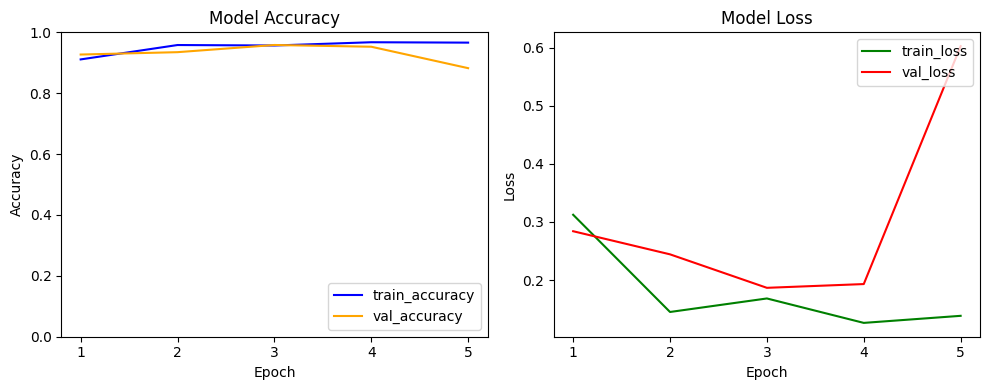

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Learning rate: 0.01,
Batch Size: 32,
Validation accuracy: 95.84%,
Test Accuracy: 91.16%.
Experiment 3 finish
*********************************************************




In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.01]
BATCH_SIZE = 32
EPOCHS = 5

for lr in learning_rate:

    print(f'*********************************************************')
    print(f'Experiment {loop} starts')

    print(f"Train the best model:\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Experiment {loop} finish')
    loop += 1

    print(f'*********************************************************\n\n')

## Learning Rate (LR) experiments results:
###Train stem_conv, block1, block2, block3 layers with the top layers
Learning rate: 0.01,
Batch Size: 32,
Validation accuracy: 95.84%,
Test Accuracy: 91.16%.

**Learning rate: 0.001, Batch Size: 32, Validation accuracy: 99.17%, Test Accuracy: 96.58%**

**Learning rate: 0.0001, Batch Size: 32, Validation accuracy: 99.53%, Test Accuracy: 96.61%.**

Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 70.99%,
Test Accuracy: 66.90%.

**Best two models will be experimented to find the optimal batch size.**

##4.2 Batch Size Experiments

Different batch sizes will be experimented on the model in the following cells the optimal learning rate.

###Compile and train the model

*********************************************************
Batch Size Experiment 1 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.8400 - loss: 0.6455 - val_accuracy: 0.9936 - val_loss: 0.0265
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.9950 - loss: 0.0204 - val_accuracy: 0.9906 - val_loss: 0.0292
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9957 - loss: 0.0159 - val_accuracy: 0.9936 - val_loss: 0.0231
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9968 - loss: 0.0138 - val_accuracy: 0.9911 - val_loss: 0.0295
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9948 - val_loss: 0.0197


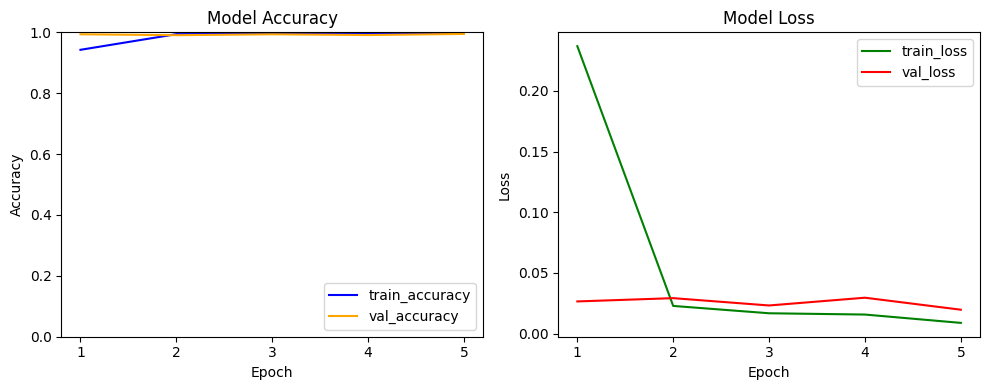

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.48%,
Test Accuracy: 96.84%.
Batch Size Experiment 1 ends
*********************************************************


*********************************************************
Batch Size Experiment 2 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.7432 - loss: 1.0360 - val_accuracy: 0.6682 - val_loss: 1.1564
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9968 - loss: 0.0281 - val_accuracy: 0.9957 - val_loss: 0.0232
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9988 - loss: 0.0099 - val_accuracy: 0.9960 - val_loss: 0.0149
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9991 - loss: 0.

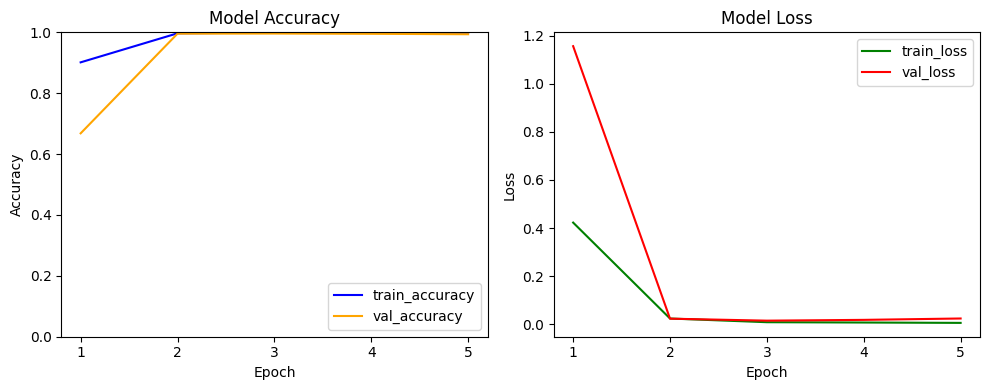

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.60%,
Test Accuracy: 96.74%.
Batch Size Experiment 2 ends
*********************************************************


*********************************************************
Batch Size Experiment 3 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.6700 - loss: 1.3530 - val_accuracy: 0.0580 - val_loss: 3.9134
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9939 - loss: 0.0545 - val_accuracy: 0.7309 - val_loss: 0.9444
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9988 - loss: 0.0176 - val_accuracy: 0.9753 - val_loss: 0.1006
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9991 - loss: 0.0090 - val_accuracy: 0.9966 - val_loss: 0.0145
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9995 - loss:

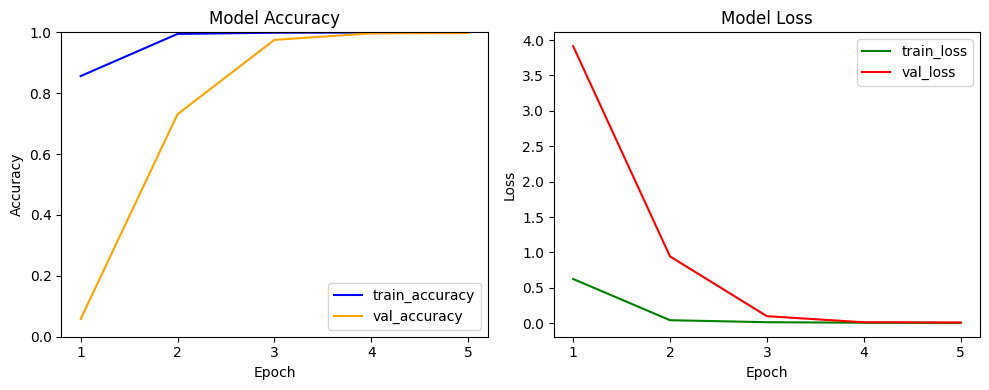

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.77%,
Test Accuracy: 97.34%.
Batch Size Experiment 3 ends
*********************************************************


*********************************************************
Batch Size Experiment 4 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.0001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.5428 - loss: 1.9284 - val_accuracy: 0.9431 - val_loss: 0.3773
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9586 - loss: 0.2900 - val_accuracy: 0.9875 - val_loss: 0.1073
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9896 - loss: 0.0928 - val_accuracy: 0.9938 - val_loss: 0.0471
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9948 - loss: 0.0420 - val_accuracy: 0.9963 - val_loss: 0.0267
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9

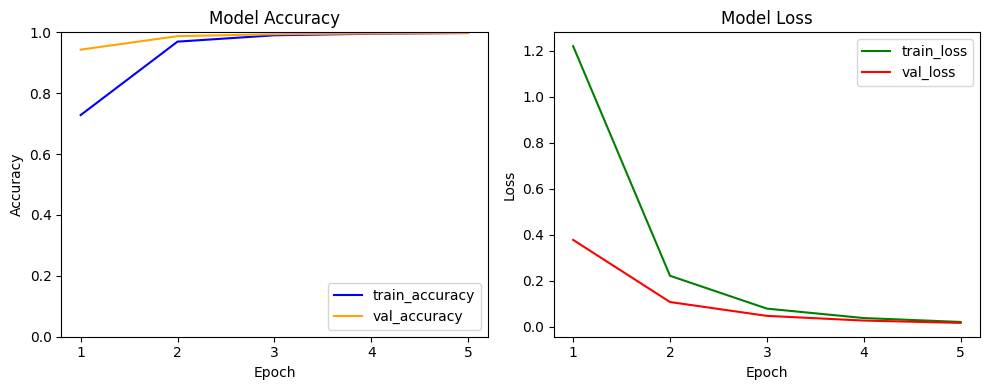

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.76%,
Test Accuracy: 97.09%.
Batch Size Experiment 4 ends
*********************************************************


*********************************************************
Batch Size Experiment 5 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.0001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.3777 - loss: 2.6082 - val_accuracy: 0.3882 - val_loss: 2.3125
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8323 - loss: 0.8808 - val_accuracy: 0.9212 - val_loss: 0.4953
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9432 - loss: 0.3888 - val_accuracy: 0.9726 - val_loss: 0.2336
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9771 - loss: 0.1992 - val_accuracy: 0.9843 - val_loss: 0.1352
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9876 - loss: 0

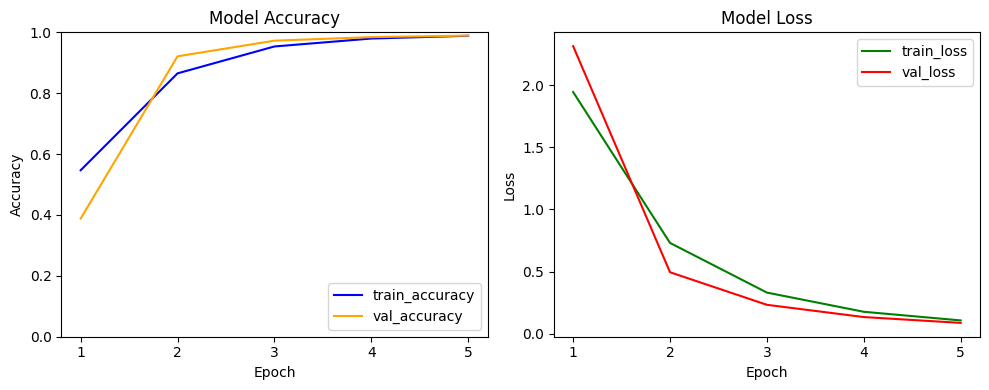

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 98.93%,
Test Accuracy: 95.48%.
Batch Size Experiment 5 ends
*********************************************************


*********************************************************
Batch Size Experiment 6 starts
Train the best EfficientNetB0 model:
Training model with learning rate = 0.0001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.2998 - loss: 2.9005 - val_accuracy: 0.0867 - val_loss: 3.5828
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7115 - loss: 1.3343 - val_accuracy: 0.4425 - val_loss: 2.1400
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8677 - loss: 0.7421 - val_accuracy: 0.8448 - val_loss: 0.7750
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9358 - loss: 0.4327 - val_accuracy: 0.9559 - val_loss: 0.3327
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9687 - los

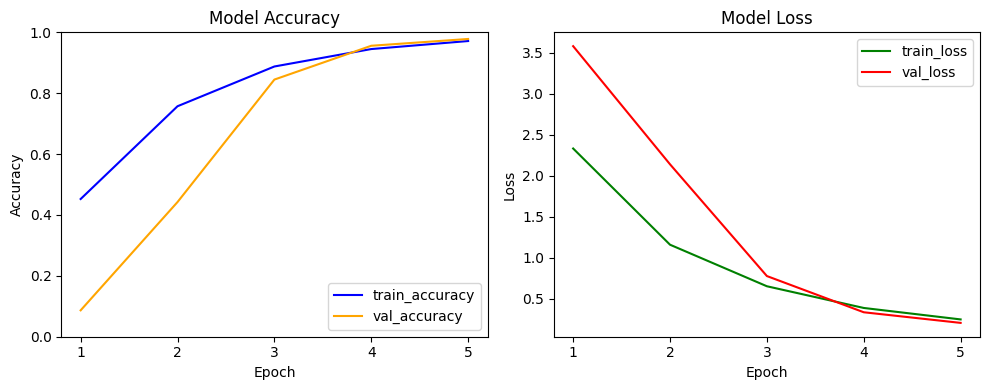

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 97.82%,
Test Accuracy: 93.42%.
Batch Size Experiment 6 ends
*********************************************************




In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001, 0.0001]
batch_sizes = [16, 64, 128]
EPOCHS = 5

loop = 1

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Batch Size Experiment {loop} starts')
    print(f"Train the best EfficientNetB0 model:\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Batch Size Experiment {loop} ends')
    loop += 1

    print(f'*********************************************************\n\n')

## Batch size experiments results:
###Train stem_conv, block1, block2, block3 layers with the top layers
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.48%,
Test Accuracy: 96.84%.

Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.60%,
Test Accuracy: 96.74%.

**Learning rate: 0.001, Batch Size: 128, Validation accuracy: 99.77%, Test Accuracy: 97.34%.**

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.76%,
Test Accuracy: 97.09%.

Learning rate: 0.0001, Batch Size: 32, Validation accuracy: 99.53%, Test Accuracy: 96.61%.

Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 98.93%,
Test Accuracy: 95.48%.

Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 97.82%,
Test Accuracy: 93.42%.

**In the next step, the best model will be trained for more epochs.**

#Part 5: Training the best model for more epochs

##Compile and train the model

###Learning rate 0.001

###Batch Sizes 128

*********************************************************
Training the best models for more epochs
Model 1 training starts
Training the best model:
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.6836 - loss: 1.3433 - val_accuracy: 0.1391 - val_loss: 3.4590
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9942 - loss: 0.0500 - val_accuracy: 0.7975 - val_loss: 0.8454
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9987 - loss: 0.0164 - val_accuracy: 0.9807 - val_loss: 0.0861
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9997 - loss: 0.0076 - val_accuracy: 0.9973 - val_loss: 0.0142
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9998 - loss: 0.0047 - val_accuracy: 0.9978 - val_loss: 0.0103
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.9990 - val_loss: 0.0061
Epoch 7/50
245/245 ━━━━━━━━━━━━━━

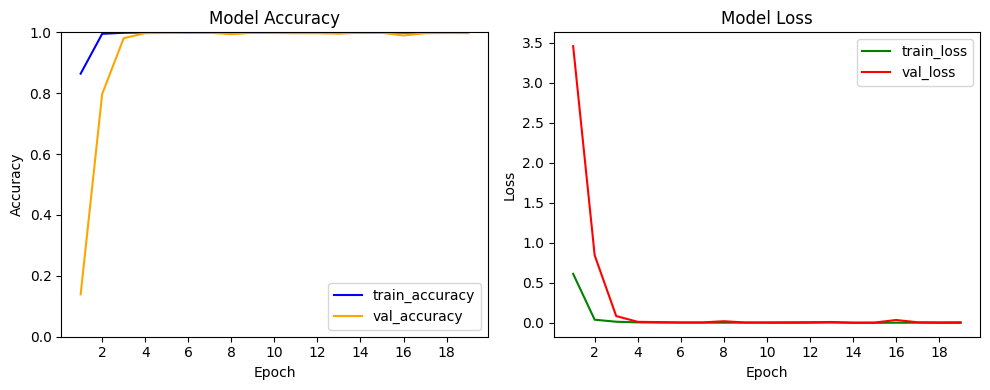

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.92%,
Test Accuracy: 98.17%.
Model 1 ends
*********************************************************




In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001]
batch_sizes = [128]
EPOCHS = 50

model_counter = 1
for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best models for more epochs')
    print(f'Model {model_counter} training starts')
    print(f"Training the best model:\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE, IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Model {model_counter} ends')
    model_counter += 1

    print(f'*********************************************************\n\n')

##Best model with more epochs results:
###Train stem_conv, block1, block2, block3 layers with the top layers
**Learning rate: 0.001, Batch Size: 128, Validation accuracy: 99.92%, Test Accuracy: 98.17%.**

#Part 6: Synthetic Minority Oversampling Technique (SMOTE)

Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented. This helps balance the dataset and improve the performance of machine learning models, particularly for imbalanced classification tasks.

In [15]:
train_images, train_labels = images, labels

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(train_images)
train_images = train_images.reshape(train_rows,-1)

train_images, train_labels = sm.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1,32,32,3)

print(f'Total number of train images and labels after applying SMOTE')
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')

Total number of train images and labels after applying SMOTE
Train images shape: (96750, 32, 32, 3)
Train labels shape: (96750, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [16]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (77400, 32, 32, 3)
Validation data shape: (19350, 32, 32, 3)


##Compile and train the model

*********************************************************
Training the best model on oversampled dataset
Train the best model:
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.8311 - loss: 0.7891 - val_accuracy: 0.8925 - val_loss: 0.4238
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9988 - loss: 0.0112 - val_accuracy: 0.9991 - val_loss: 0.0067
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 0.9983 - val_loss: 0.0079
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9976 - val_loss: 0.0081
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9991 - val_loss: 0.0041
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9976 - val_loss: 0.0103
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step

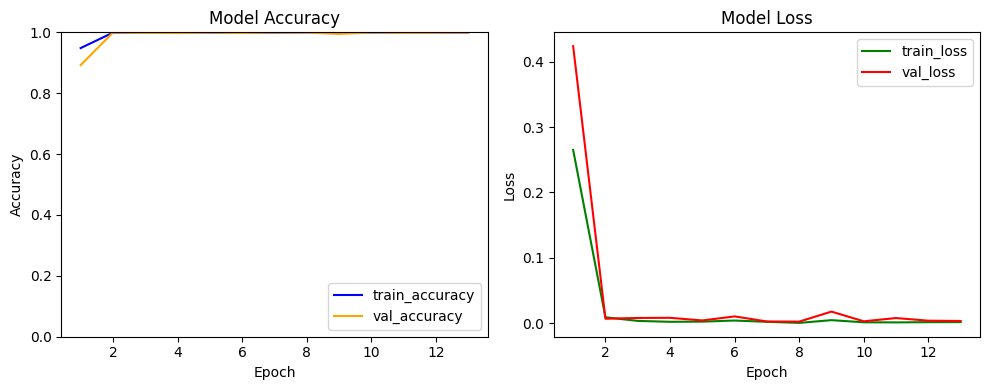

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.93%,
Test Accuracy: 97.80%.
*********************************************************




In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set best parameters
batch_sizes = [128]
learning_rate = [0.001]
EPOCHS = 50

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best model on oversampled dataset')
    print(f"Train the best model:\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_EfficientNetB0_model_block3a_project_conv((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'*********************************************************\n\n')

##Best model on oversampled dataset results:
###Train stem_conv, block1, block2, block3 layers with the top layers
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.93%,
Test Accuracy: 97.80%.


#Conclusion
**Best model:**<br>
###Train stem_conv, block1, block2, block3 layers of EfficientNetB0 with the top layers
**parameters:** <br>
Learning rate: 0.001<br>
Batch size: 128<br>
**Best Accuracy:** **97.80%**.

